In [1]:
import pandas as pd
import numpy as np
import oracledb
from sqlalchemy import create_engine
import os
import glob
pd.set_option('display.max_columns',100)
import time
import seaborn as sns
import matplotlib.pyplot as plt

- Bad debt: Accounts with >=30 days DPD

# A. Query Data

In [2]:
# credentials
username = os.environ['DBA_USR']
password = os.environ['DBA_PW']
host = '10.220.50.121'
port = '1661'
service_name = 'ANALYTIC'

In [3]:
connection_string = f'oracle+oracledb://{username}:{password}@{host}:{port}/?service_name={service_name}'

In [4]:
# create engine
engine = create_engine(connection_string)

In [5]:
# create list of all dates
allDates = ['20241031','20240930','20240829','20240731','20240628','20240531',
            '20240430','20240328','20240229','20240131','20231229','20231130']
# no dpd for <202404

In [6]:
# open sql file 360
with open("CCPull_CUST360.sql", 'r') as file:
    query_360 = file.read()

# open sql PORTFOLIO
with open("CCPull_CUSTPORT.sql", 'r') as file:
    query_PORTFOLIO = file.read()

In [7]:
# print(query_template.format(dt='20241031'))

In [8]:
allMLs = []
for date in allDates:
    yearmonth = date[2:6]
    if int(date) > 20240329:
        try:
            # print in case of errors
            print(f'Running {date}')

            # open and read the file as a single buffer
            sqlQuery = query_360.format(dt=date)

            # run query and store data in df
            print('SQL run')
            with engine.connect() as connection:
                ML = pd.read_sql(sqlQuery, connection) 
            print(f'{date} queried successfully')

            # change column names into UPPER CASE
            ML.columns = [x.upper() for x in ML.columns]
        except Exception as e:
            print(e)
            ML = pd.DataFrame()
        finally:
            allMLs.append(ML)

            time.sleep(5)
    else:
        try:
            # print in case of errors
            print(f'Running {date}')

            # open and read the file as a single buffer
            sqlQuery = query_PORTFOLIO.format(dt=date, ym=yearmonth)

            # run query and store data in df
            print('SQL run')
            with engine.connect() as connection:
                ML = pd.read_sql(sqlQuery, connection) 
            print(f'{date} queried successfully')

            # change column names into UPPER CASE
            ML.columns = [x.upper() for x in ML.columns]
        except Exception as e:
            print(e)
            ML = pd.DataFrame()
        finally:
            allMLs.append(ML)

            time.sleep(5)

Running 20241031
SQL run
20241031 queried successfully
Running 20240930
SQL run
20240930 queried successfully
Running 20240829
SQL run
20240829 queried successfully
Running 20240731
SQL run
20240731 queried successfully
Running 20240628
SQL run
20240628 queried successfully
Running 20240531
SQL run
20240531 queried successfully
Running 20240430
SQL run
20240430 queried successfully
Running 20240328
SQL run
20240328 queried successfully
Running 20240229
SQL run
20240229 queried successfully
Running 20240131
SQL run
20240131 queried successfully
Running 20231229
SQL run
20231229 queried successfully
Running 20231130
SQL run
20231130 queried successfully


In [9]:
allMLs[7].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182350 entries, 0 to 182349
Data columns (total 79 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   BASE_DT           182350 non-null  object        
 1   AGREE_ID          182350 non-null  object        
 2   GCIF_NO           182350 non-null  object        
 3   CIF_NO            182350 non-null  object        
 4   NOTE_NO           182350 non-null  object        
 5   PRD_TP            182350 non-null  object        
 6   PRD_NM            182350 non-null  object        
 7   PRD_SEGMENT       182350 non-null  object        
 8   ORG_LMT_AMT       182350 non-null  float64       
 9   CURR_LMT_AMT      182350 non-null  float64       
 10  BAL               182350 non-null  float64       
 11  ORIG_INT_RT       182350 non-null  float64       
 12  CURR_INT_RT       182350 non-null  float64       
 13  OTH_CURR_INT_RT   182350 non-null  float64       
 14  CLCT

# B. EDA

## 1. By Account

In [10]:
# concat all MLs into one
MLs = pd.concat(allMLs, ignore_index=True)

In [11]:
# show all df cols
MLs.columns

Index(['BASE_DT', 'AGREE_ID', 'GCIF_NO', 'CIF_NO', 'NOTE_NO', 'PRD_TP',
       'PRD_NM', 'PRD_SEGMENT', 'ORG_LMT_AMT', 'CURR_LMT_AMT', 'BAL',
       'ORIG_INT_RT', 'CURR_INT_RT', 'OTH_CURR_INT_RT', 'CLCT_RTNG_FCL',
       'ALLOW_PCT', 'ALLOW_PCT_ADD', 'RESTRUCT_CD', 'PASTDUE_SINCE_DT',
       'PASTDUE_DAYS', 'WRITE_OFF_AMT', 'WRITE_OFF_DT', 'WRITE_OFF_YN',
       'CC_STATUS', 'GCIF_NO', 'SEGMENT', 'CUST_NM', 'OPEN_DATE',
       'LAST_ACTIVE_DATE', 'CUST_TP', 'GENDER_CD', 'AGE', 'SAGA_FLAG',
       'EMPLOYMENT_TYPE', 'CA_BAL', 'CA_AVG', 'SA_BAL', 'SA_AVG', 'TD_NOA',
       'TD_BAL', 'TD_AVG', 'SY_FUNDING_BAL', 'SY_FUNDING_AVG', 'FUNDING_NOA',
       'FUNDING_BAL', 'FUNDING_AVG', 'NOA_DORMANT', 'CC_PLAFOND', 'CC_BAL',
       'PL_PLAFOND', 'PLOAN_BAL', 'TR_PLAFOND', 'TR_BAL', 'PB_PLAFOND',
       'PB_BAL', 'PRK_PLAFOND', 'PRK_BAL', 'PPB_PLAFOND', 'PPB_BAL',
       'BG_PLAFOND', 'BG_BAL', 'LC_PLAFOND', 'LC_BAL', 'SY_LOAN_PLAFOND',
       'SY_LOAN_BAL', 'KPR_PLAFOND', 'KPR_BAL', 'KPM_PLAFON

In [12]:
# drop in case of duplicated colname
MLs = MLs.loc[:, ~MLs.columns.duplicated()].copy()

In [13]:
# check saga value count
MLs['SAGA_FLAG'].value_counts()

SAGA_FLAG
NON-SAGA    1209373
SAGA         941609
Name: count, dtype: int64

In [14]:
MLs[['PASTDUE_DAYS','CC_STATUS']].value_counts()

PASTDUE_DAYS  CC_STATUS 
0             PERFORMING    2108866
30            DELINQUENT      10727
60            DELINQUENT       6189
90            DELINQUENT       4365
120           DELINQUENT       3585
150           DELINQUENT       2842
210           DELINQUENT         62
180           DELINQUENT          5
Name: count, dtype: int64

In [15]:
MLs[MLs['SAGA_FLAG']=='SAGA'][['PASTDUE_DAYS','CC_STATUS']].value_counts()

PASTDUE_DAYS  CC_STATUS 
0             PERFORMING    911481
30            DELINQUENT      4702
60            DELINQUENT      2466
90            DELINQUENT      1792
120           DELINQUENT      1496
150           DELINQUENT      1196
210           DELINQUENT        30
180           DELINQUENT         1
Name: count, dtype: int64

### a. SAGA vs ALL Delinquency

In [16]:
# SAGA delinquency aggregate
SAGADeliCount = MLs[(MLs['CC_STATUS']=='DELINQUENT') & (MLs['SAGA_FLAG']=='SAGA')][[
    'BASE_DT', 'AGREE_ID', 'BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          OS=('BAL','sum')).reset_index()
SAGADeliCount['MICRO_SEGMENT'] = 'SAGA'
SAGADeliCount['CATEGORY'] = 'DELINQUENT'

In [17]:
SAGADeliCount

,BASE_DT,ACCT_COUNT,OS,MICRO_SEGMENT,CATEGORY
0,20231130,1007,2.521953e+10,SAGA,DELINQUENT
1,20231229,977,2.725033e+10,SAGA,DELINQUENT
2,20240131,961,2.807185e+10,SAGA,DELINQUENT
3,20240229,1006,2.796780e+10,SAGA,DELINQUENT
4,20240328,1062,2.916743e+10,SAGA,DELINQUENT
5,20240430,994,3.157295e+10,SAGA,DELINQUENT
6,20240531,1016,3.248646e+10,SAGA,DELINQUENT
7,20240628,1060,3.502505e+10,SAGA,DELINQUENT
8,20240731,1038,3.206550e+10,SAGA,DELINQUENT
9,20240829,952,3.169239e+10,SAGA,DELINQUENT


In [18]:
# Total delinquency aggregate
TotalDeliCount = MLs[(MLs['CC_STATUS']=='DELINQUENT')][[
    'BASE_DT', 'AGREE_ID', 'BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          OS=('BAL','sum')).reset_index()
TotalDeliCount['MICRO_SEGMENT'] = 'ALL'
TotalDeliCount['CATEGORY'] = 'DELINQUENT'

In [19]:
TotalDeliCount

,BASE_DT,ACCT_COUNT,OS,MICRO_SEGMENT,CATEGORY
0,20231130,2486,5.146517e+10,ALL,DELINQUENT
1,20231229,2322,5.139953e+10,ALL,DELINQUENT
2,20240131,2221,5.211538e+10,ALL,DELINQUENT
3,20240229,2375,5.410855e+10,ALL,DELINQUENT
4,20240328,2484,5.745158e+10,ALL,DELINQUENT
5,20240430,2297,6.132662e+10,ALL,DELINQUENT
6,20240531,2304,6.151929e+10,ALL,DELINQUENT
7,20240628,2392,6.644884e+10,ALL,DELINQUENT
8,20240731,2398,6.246609e+10,ALL,DELINQUENT
9,20240829,2348,6.334926e+10,ALL,DELINQUENT


In [20]:
# concat deli count
AllDeliCount = pd.concat([SAGADeliCount, TotalDeliCount], ignore_index=True)

# format data
AllDeliCount['BASE_DT'] = AllDeliCount['BASE_DT'].str[2:6]

<Axes: title={'center': 'DELINQUENCY_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

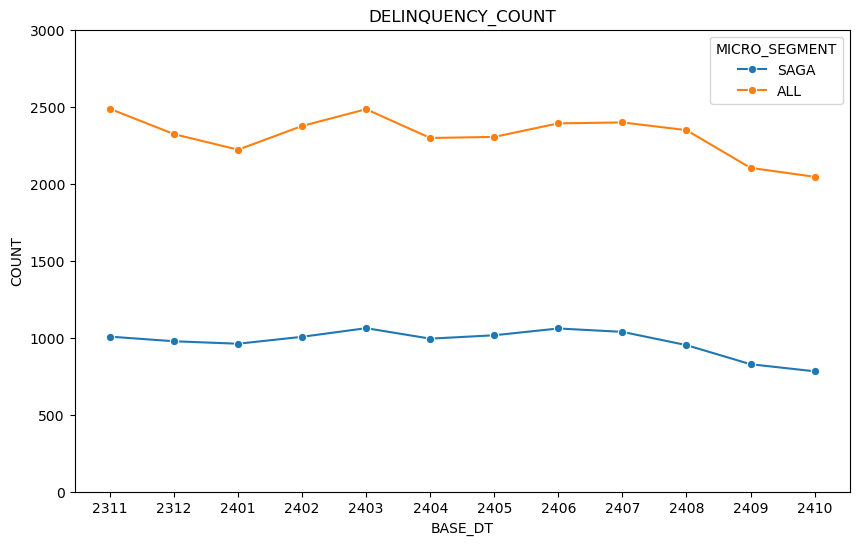

In [67]:
# Plot delinquency count per month
plt.figure(figsize=(10,6))
plt.title("DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
plt.ylim((0,3000))
sns.lineplot(data=AllDeliCount, x="BASE_DT", y='ACCT_COUNT', hue='MICRO_SEGMENT', marker="o")

<Axes: title={'center': 'DELINQUENT_OS'}, xlabel='BASE_DT', ylabel='AMOUNT'>

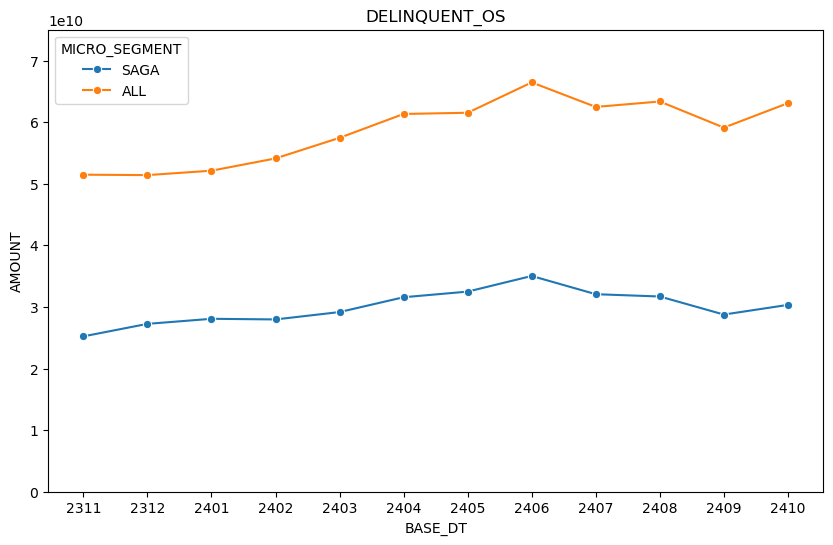

In [66]:
# Plot delinquent OS per month
plt.figure(figsize=(10,6))
plt.title("DELINQUENT_OS")
plt.xlabel("BASE_DT")
plt.ylabel("AMOUNT")
plt.ylim((0,75000000000))
sns.lineplot(data=AllDeliCount, x="BASE_DT", y='OS', hue='MICRO_SEGMENT', marker="o")

### b. SAGA Total vs Delinquency

In [23]:
# Total delinquency aggregate
SAGACount = MLs[(MLs['SAGA_FLAG']=='SAGA')][[
    'BASE_DT', 'AGREE_ID', 'BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          OS=('BAL','sum')).reset_index()
SAGACount['MICRO_SEGMENT'] = 'SAGA'
SAGACount['CATEGORY'] = 'ALL'

In [24]:
# concat the data
AllSAGACount = pd.concat([SAGADeliCount, SAGACount], ignore_index=True)

# format base_dt
AllSAGACount['BASE_DT'] = AllSAGACount['BASE_DT'].str[2:6]

In [25]:
AllSAGACount

,BASE_DT,ACCT_COUNT,OS,MICRO_SEGMENT,CATEGORY
0,2311,1007,2.521953e+10,SAGA,DELINQUENT
1,2312,977,2.725033e+10,SAGA,DELINQUENT
2,2401,961,2.807185e+10,SAGA,DELINQUENT
3,2402,1006,2.796780e+10,SAGA,DELINQUENT
4,2403,1062,2.916743e+10,SAGA,DELINQUENT
5,2404,994,3.157295e+10,SAGA,DELINQUENT
6,2405,1016,3.248646e+10,SAGA,DELINQUENT
7,2406,1060,3.502505e+10,SAGA,DELINQUENT
8,2407,1038,3.206550e+10,SAGA,DELINQUENT
9,2408,952,3.169239e+10,SAGA,DELINQUENT


<Axes: title={'center': 'SAGA_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

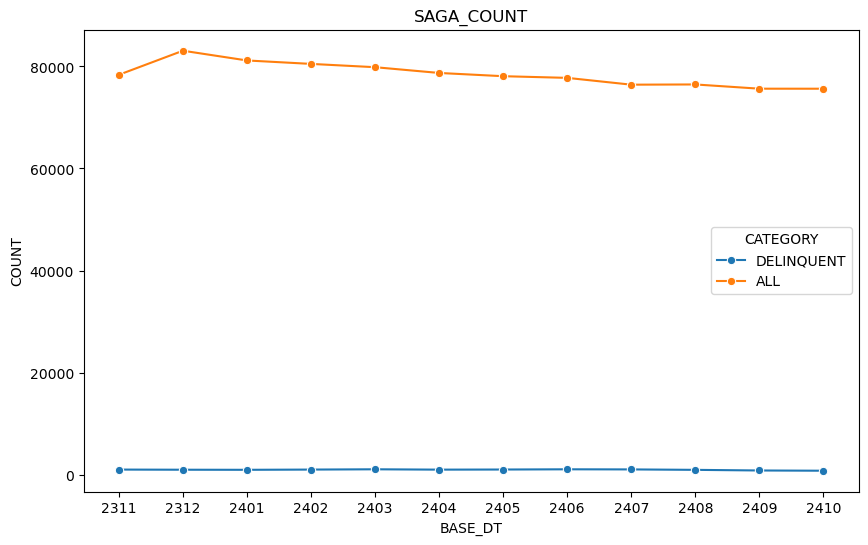

In [26]:
# Plot SAGA count per month
plt.figure(figsize=(10,6))
plt.title("SAGA_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
# plt.ylim((0,2000))
sns.lineplot(data=AllSAGACount, x="BASE_DT", y='ACCT_COUNT', hue='CATEGORY', marker="o")

<Axes: title={'center': 'SAGA_OS'}, xlabel='BASE_DT', ylabel='COUNT'>

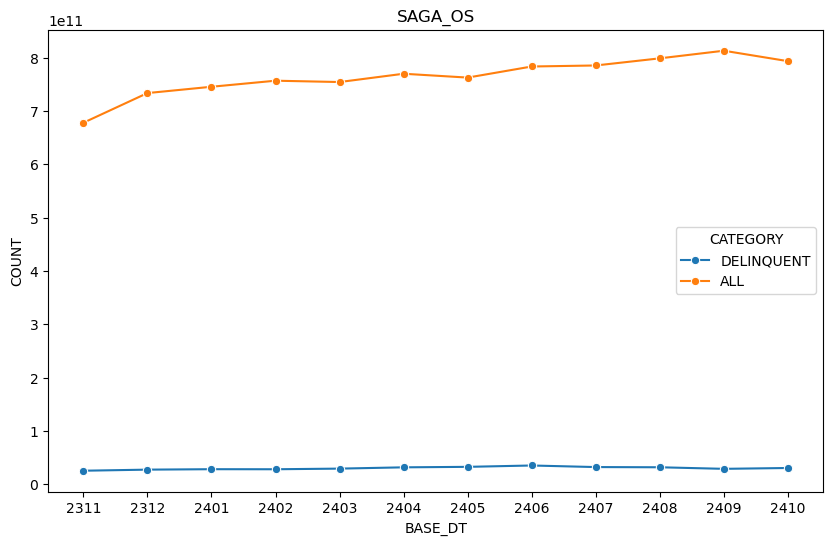

In [27]:
# Plot SAGA count per month
plt.figure(figsize=(10,6))
plt.title("SAGA_OS")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
# plt.ylim((0,2000))
sns.lineplot(data=AllSAGACount, x="BASE_DT", y='OS', hue='CATEGORY', marker="o")

In [28]:
# create wide df to calaculate percentage
AllSagaCountWide = AllSAGACount[AllSAGACount['CATEGORY']=='DELINQUENT'].merge(
    AllSAGACount[AllSAGACount['CATEGORY']=='ALL'], on='BASE_DT', how='left')

In [29]:
# fix field names and shi
AllSagaCountWide.columns = ['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'OS_DELINQUENT','MICRO_SEGMENT_x', 'CATEGORY_x',
       'ACCT_COUNT_ALL', 'OS_ALL', 'MICRO_SEGMENT', 'CATEGORY_y']
AllSagaCountWide = AllSagaCountWide[['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'OS_DELINQUENT',
       'ACCT_COUNT_ALL', 'OS_ALL', 'MICRO_SEGMENT']]

In [30]:
AllSagaCountWide

,BASE_DT,ACCT_COUNT_DELINQUENT,OS_DELINQUENT,ACCT_COUNT_ALL,OS_ALL,MICRO_SEGMENT
0,2311,1007,2.521953e+10,78358,6.778613e+11,SAGA
1,2312,977,2.725033e+10,83071,7.335104e+11,SAGA
2,2401,961,2.807185e+10,81163,7.453515e+11,SAGA
3,2402,1006,2.796780e+10,80489,7.567105e+11,SAGA
4,2403,1062,2.916743e+10,79843,7.542105e+11,SAGA
5,2404,994,3.157295e+10,78715,7.697663e+11,SAGA
6,2405,1016,3.248646e+10,78079,7.625431e+11,SAGA
7,2406,1060,3.502505e+10,77752,7.833538e+11,SAGA
8,2407,1038,3.206550e+10,76418,7.852823e+11,SAGA
9,2408,952,3.169239e+10,76462,7.986619e+11,SAGA


In [31]:
# calculate count share
AllSagaCountWide['ACCT_COUNT_SHARE'] = AllSagaCountWide['ACCT_COUNT_DELINQUENT']/AllSagaCountWide['ACCT_COUNT_ALL']

# calculate os share
AllSagaCountWide['OS_SHARE'] = AllSagaCountWide['OS_DELINQUENT']/AllSagaCountWide['OS_ALL']

In [32]:
# longify for visualization
CountShare = AllSagaCountWide[['BASE_DT','ACCT_COUNT_SHARE']]
CountShare.columns = ['BASE_DT','SHARE']
CountShare['VAR'] = 'COUNT'

OSShare = AllSagaCountWide[['BASE_DT','OS_SHARE']]
OSShare.columns = ['BASE_DT','SHARE']
OSShare['VAR'] = 'OS'

# concat the 2 tables
AllShare = pd.concat([CountShare,OSShare], ignore_index=True)
AllShare['BASE_DT'] = AllShare['BASE_DT'].str[2:6]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_7508\2811820419.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CountShare['VAR'] = 'COUNT'
C:\Users\MR38804\AppData\Local\Temp\ipykernel_7508\2811820419.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OSShare['VAR'] = 'OS'


<Axes: title={'center': 'SAGA_DELINQUENCY_SHARE'}, xlabel='BASE_DT', ylabel='SHARE'>

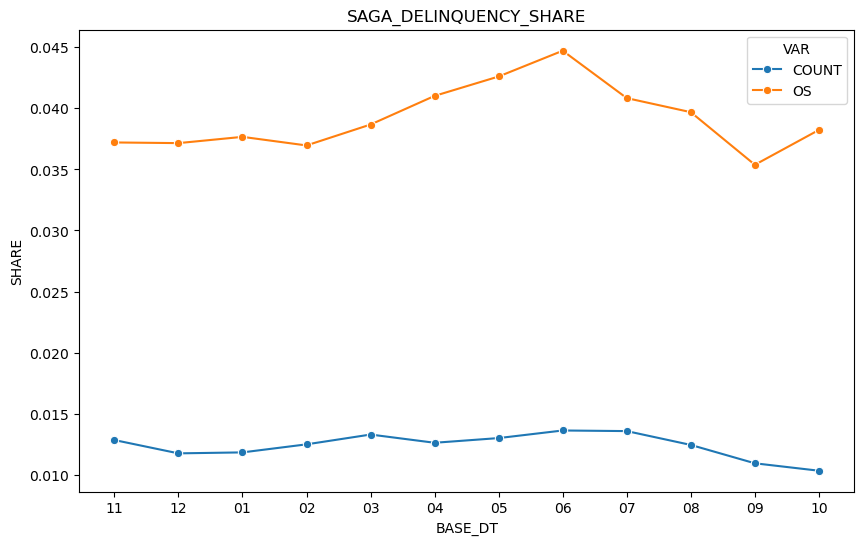

In [33]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("SAGA_DELINQUENCY_SHARE")
plt.xlabel("BASE_DT")
plt.ylabel("SHARE")
sns.lineplot(data=AllShare, x="BASE_DT", y='SHARE', hue='VAR', marker="o")

### c. All Total vs Delinquent

In [34]:
# total deli count (review)
TotalDeliCount

,BASE_DT,ACCT_COUNT,OS,MICRO_SEGMENT,CATEGORY
0,20231130,2486,5.146517e+10,ALL,DELINQUENT
1,20231229,2322,5.139953e+10,ALL,DELINQUENT
2,20240131,2221,5.211538e+10,ALL,DELINQUENT
3,20240229,2375,5.410855e+10,ALL,DELINQUENT
4,20240328,2484,5.745158e+10,ALL,DELINQUENT
5,20240430,2297,6.132662e+10,ALL,DELINQUENT
6,20240531,2304,6.151929e+10,ALL,DELINQUENT
7,20240628,2392,6.644884e+10,ALL,DELINQUENT
8,20240731,2398,6.246609e+10,ALL,DELINQUENT
9,20240829,2348,6.334926e+10,ALL,DELINQUENT


In [35]:
# Total aggregate
TotalCount = MLs[[
    'BASE_DT', 'AGREE_ID', 'BAL'
]].groupby('BASE_DT').agg(ACCT_COUNT=('AGREE_ID','count'),
                          OS=('BAL','sum')).reset_index()
TotalCount['MICRO_SEGMENT'] = 'ALL'
TotalCount['CATEGORY'] = 'ALL'

In [36]:
# concat tables
AllAll = pd.concat([TotalDeliCount,TotalCount], ignore_index=True)

# format base_dt
AllAll['BASE_DT'] = AllAll['BASE_DT'].str[2:6]

In [37]:
AllAll

,BASE_DT,ACCT_COUNT,OS,MICRO_SEGMENT,CATEGORY
0,2311,2486,5.146517e+10,ALL,DELINQUENT
1,2312,2322,5.139953e+10,ALL,DELINQUENT
2,2401,2221,5.211538e+10,ALL,DELINQUENT
3,2402,2375,5.410855e+10,ALL,DELINQUENT
4,2403,2484,5.745158e+10,ALL,DELINQUENT
5,2404,2297,6.132662e+10,ALL,DELINQUENT
6,2405,2304,6.151929e+10,ALL,DELINQUENT
7,2406,2392,6.644884e+10,ALL,DELINQUENT
8,2407,2398,6.246609e+10,ALL,DELINQUENT
9,2408,2348,6.334926e+10,ALL,DELINQUENT


<Axes: title={'center': 'ALL_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

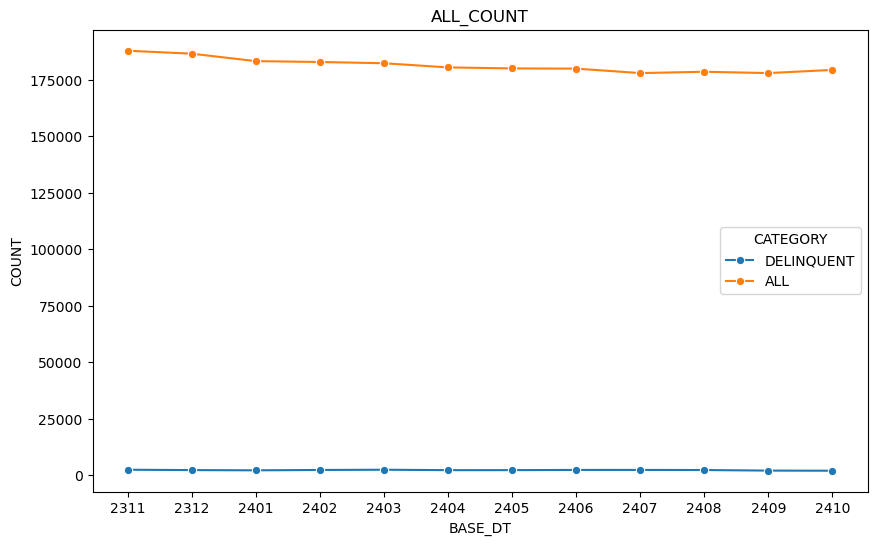

In [38]:
# Plot All count per month
plt.figure(figsize=(10,6))
plt.title("ALL_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
# plt.ylim((0,2000))
sns.lineplot(data=AllAll, x="BASE_DT", y='ACCT_COUNT', hue='CATEGORY', marker="o")

<Axes: title={'center': 'ALL_OS'}, xlabel='BASE_DT', ylabel='OS'>

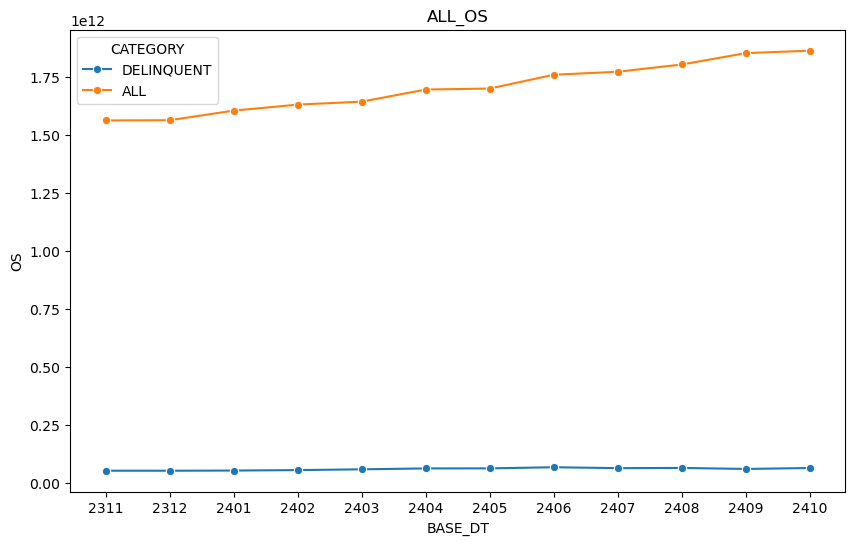

In [39]:
# Plot All count per month
plt.figure(figsize=(10,6))
plt.title("ALL_OS")
plt.xlabel("BASE_DT")
plt.ylabel("OS")
# plt.ylim((0,2000))
sns.lineplot(data=AllAll, x="BASE_DT", y='OS', hue='CATEGORY', marker="o")

In [40]:
# create wide df to calaculate percentage
AllCountWide = AllAll[AllAll['CATEGORY']=='DELINQUENT'].merge(
    AllAll[AllAll['CATEGORY']=='ALL'], on='BASE_DT', how='left')

In [41]:
# fix field names and shi
AllCountWide.columns = ['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'OS_DELINQUENT','MICRO_SEGMENT_x', 'CATEGORY_x',
       'ACCT_COUNT_ALL', 'OS_ALL', 'MICRO_SEGMENT', 'CATEGORY_y']
AllCountWide = AllCountWide[['BASE_DT', 'ACCT_COUNT_DELINQUENT', 'OS_DELINQUENT',
       'ACCT_COUNT_ALL', 'OS_ALL', 'MICRO_SEGMENT']]

In [42]:
# calculate count share
AllCountWide['ACCT_COUNT_SHARE'] = AllCountWide['ACCT_COUNT_DELINQUENT']/AllCountWide['ACCT_COUNT_ALL']

# calculate os share
AllCountWide['OS_SHARE'] = AllCountWide['OS_DELINQUENT']/AllCountWide['OS_ALL']

In [43]:
# longify for visualization
AllCountShare = AllCountWide[['BASE_DT','ACCT_COUNT_SHARE']]
AllCountShare.columns = ['BASE_DT','SHARE']
AllCountShare['VAR'] = 'COUNT'

AllOSShare = AllCountWide[['BASE_DT','OS_SHARE']]
AllOSShare.columns = ['BASE_DT','SHARE']
AllOSShare['VAR'] = 'OS'

# concat the 2 tables
AllAllShare = pd.concat([AllCountShare,AllOSShare], ignore_index=True)
#AllAllShare['BASE_DT'] = AllAllShare['BASE_DT'].str[2:6]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_7508\1748476280.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllCountShare['VAR'] = 'COUNT'
C:\Users\MR38804\AppData\Local\Temp\ipykernel_7508\1748476280.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllOSShare['VAR'] = 'OS'


<Axes: title={'center': 'TOTAL_DELINQUENCY_SHARE'}, xlabel='BASE_DT', ylabel='SHARE'>

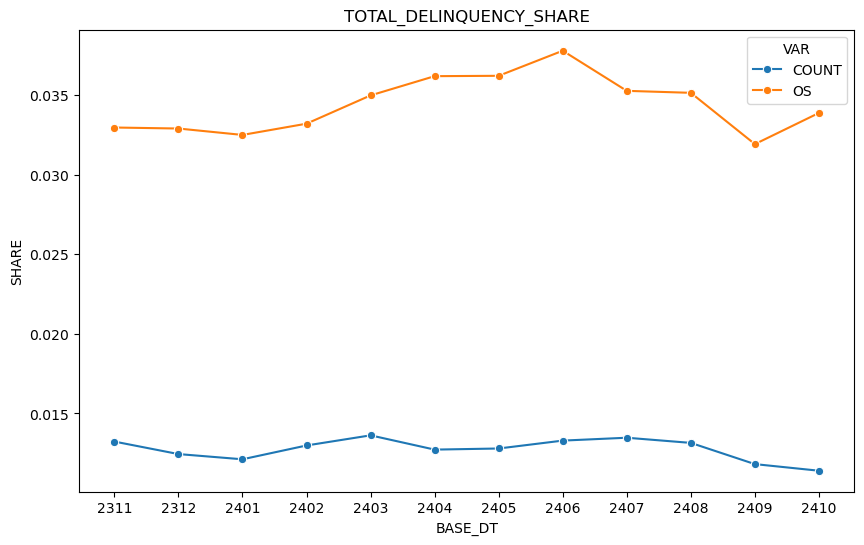

In [44]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("TOTAL_DELINQUENCY_SHARE")
plt.xlabel("BASE_DT")
plt.ylabel("SHARE")
sns.lineplot(data=AllAllShare, x="BASE_DT", y='SHARE', hue='VAR', marker="o")

### d. SAGA Monthly New Delinquent

In [ ]:
# set dataframe for dpd change calculation
DPDMonthly = MLs[['BASE_DT', 'AGREE_ID', 'PASTDUE_DAYS']].reset_index()

In [46]:
# checking pastdue values
DPDMonthly['PASTDUE_DAYS'].value_counts()

PASTDUE_DAYS
0      2108866
1        40809
30       10727
60        6189
90        4365
120       3585
150       2842
210         62
180          5
Name: count, dtype: int64

In [47]:
# create pivot table
DPDMonthlyPivot = DPDMonthly.pivot(index='AGREE_ID',
                                   columns='BASE_DT',
                                   values='PASTDUE_DAYS')

In [48]:
# flaten columns
DPDMonthlyPivot = DPDMonthlyPivot.rename_axis(index=None, columns=None).reset_index()

In [49]:
DPDMonthlyPivot.columns

Index(['index', '20231130', '20231229', '20240131', '20240229', '20240328',
       '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
       '20241031'],
      dtype='object')

In [50]:
# rename columns
DPDMonthlyPivot.columns = [
    'AGREE_ID', '20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']

In [51]:
# fillna with 0
DPDMonthlyPivot.fillna(0, inplace=True)

# date for loop
dateCol = ['20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']

# calculate dpd change for all dates
for i in range(1,len(dateCol)):
    prevDate = dateCol[i-1]
    date = dateCol[i]
    DPDMonthlyPivot[f'DELINQUENT_{date}'] = DPDMonthlyPivot.apply(
        lambda x: 1 if x[prevDate]<30 and x[date]>=30 else 0,
        axis=1)

In [52]:
# check value
DPDMonthlyPivot[['DELINQUENT_20240430']].value_counts()

DELINQUENT_20240430
0                      255118
1                         579
Name: count, dtype: int64

In [53]:
# take only used cols
usedCols = [list(DPDMonthlyPivot.columns)[0]]+list(DPDMonthlyPivot.columns)[13:]
DPDMonthlyPivot = DPDMonthlyPivot[usedCols]

In [54]:
# longify
DPDMonthlyLong = pd.wide_to_long(DPDMonthlyPivot,
                                 stubnames='DELINQUENT',
                                 i = 'AGREE_ID',
                                 j = 'BASE_DT',
                                 sep = '_')

In [55]:
# reset index and change base_dt type to string
DPDMonthlyLong = DPDMonthlyLong.reset_index()
DPDMonthlyLong['BASE_DT'] = DPDMonthlyLong['BASE_DT'].astype(str)

In [56]:
DPDMonthlyLong.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2812667 entries, 0 to 2812666
Data columns (total 3 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   AGREE_ID    object
 1   BASE_DT     object
 2   DELINQUENT  int64 
dtypes: int64(1), object(2)
memory usage: 64.4+ MB


In [57]:
# merge delinquency flag to original data
MLs = MLs.merge(DPDMonthlyLong[['AGREE_ID', 'BASE_DT', 'DELINQUENT']], on=['AGREE_ID', 'BASE_DT'], how='left')

In [58]:
MLs['DELINQUENT'].value_counts()

DELINQUENT
0.0    1982292
1.0       7273
Name: count, dtype: int64

In [59]:
# group data for visualization
monthlyDeli = MLs[(MLs['SAGA_FLAG']=='SAGA') & (MLs['DELINQUENT']==1)][['BASE_DT', 'DELINQUENT', 'BAL']].groupby('BASE_DT').agg(ACCT_COUNT=('DELINQUENT','sum'), OS=('BAL','sum')).reset_index()
monthlyDeliAll = MLs[MLs['DELINQUENT']==1][['BASE_DT', 'DELINQUENT','BAL']].groupby('BASE_DT').agg(ACCT_COUNT=('DELINQUENT','sum'), OS=('BAL','sum')).reset_index()

In [60]:
# flag data
monthlyDeli['MICRO_SEGMENT'] = 'SAGA'
monthlyDeliAll['MICRO_SEGMENT'] = 'ALL'

In [61]:
# combine the data
MonthlyDeliComb = pd.concat([monthlyDeli,monthlyDeliAll], ignore_index=True)

# format data
MonthlyDeliComb['BASE_DT'] = MonthlyDeliComb['BASE_DT'].str[2:6]

# exclude first month because no data of new delinquency
MonthlyDeliComb = MonthlyDeliComb[MonthlyDeliComb['BASE_DT']!='2311']

<Axes: title={'center': 'MONTHLY_DELINQUENCY_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

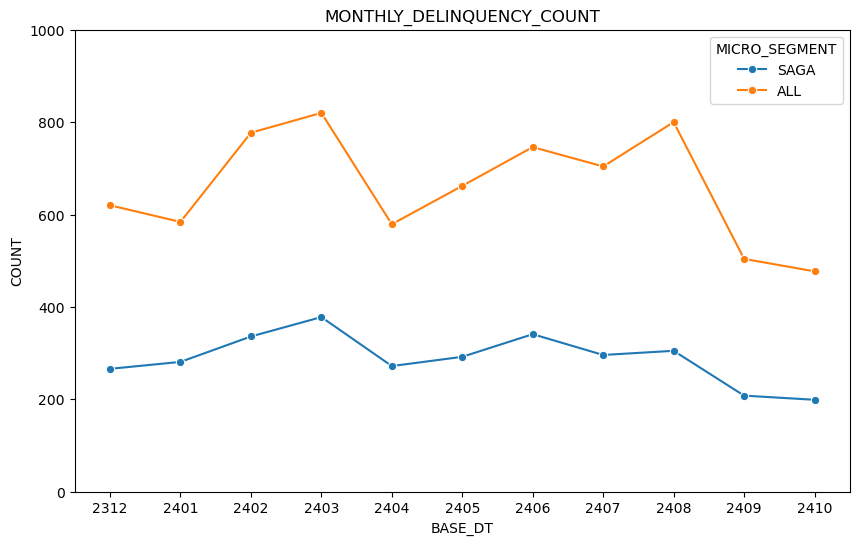

In [62]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("MONTHLY_DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylim((0,1000))
plt.ylabel("COUNT")
sns.lineplot(data=MonthlyDeliComb, x="BASE_DT", y='ACCT_COUNT', hue='MICRO_SEGMENT', marker="o")

<Axes: title={'center': 'MONTHLY_DELINQUENCY_os'}, xlabel='BASE_DT', ylabel='os'>

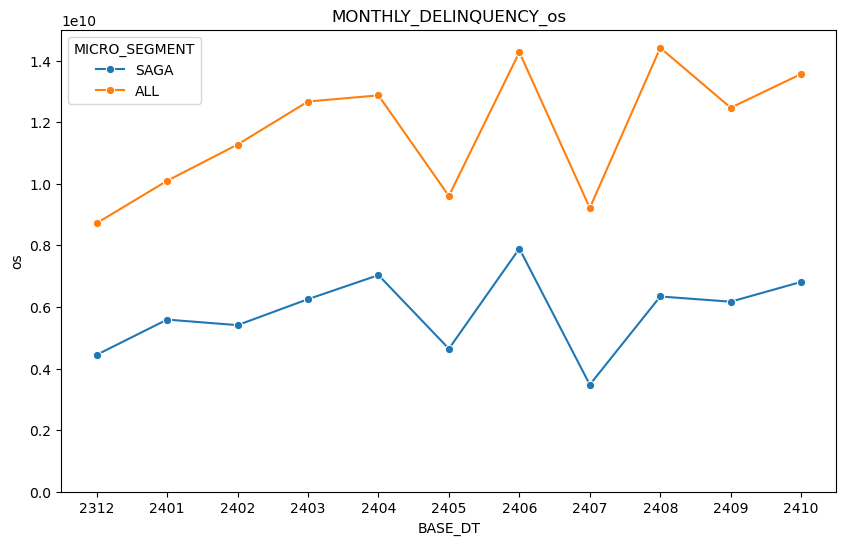

In [63]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("MONTHLY_DELINQUENCY_os")
plt.xlabel("BASE_DT")
plt.ylim((0,15000000000))
plt.ylabel("os")
sns.lineplot(data=MonthlyDeliComb, x="BASE_DT", y='OS', hue='MICRO_SEGMENT', marker="o")

## 2. By GCIF

In [69]:
# create GCIF grouped data
MLsGCIFGPD = MLs[['BASE_DT','GCIF_NO','CURR_LMT_AMT','BAL']].groupby(
    ['BASE_DT','GCIF_NO']).agg(
        SUM_LMT=('CURR_LMT_AMT','sum'),
        SUM_BAL=('BAL','sum'),
        NOA=('BASE_DT','count')
    ).reset_index()

In [70]:
# create separate df for categorical
MLsGCIFProc = MLs[['BASE_DT','GCIF_NO','SAGA_FLAG','PASTDUE_DAYS']]

In [71]:
# map to integer SAGA flag
SAGAMap = {'SAGA':1,'NON-SAGA':0}
MLsGCIFProc['SAGA_FLAG'] = MLsGCIFProc['SAGA_FLAG'].map(SAGAMap)

C:\Users\MR38804\AppData\Local\Temp\ipykernel_7508\49022384.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MLsGCIFProc['SAGA_FLAG'] = MLsGCIFProc['SAGA_FLAG'].map(SAGAMap)


In [72]:
# create categorical GCIF grouped data
MLsGCIFGPD2 = MLsGCIFProc.groupby(
    ['BASE_DT','GCIF_NO']).agg(
        SAGA_FLAG=('SAGA_FLAG','max'),
        PASTDUE_DAYS_MAX=('PASTDUE_DAYS','max'),
).reset_index()

In [73]:
MLsGCIFGPD.duplicated(subset=['BASE_DT','GCIF_NO']).sum()

0

In [74]:
MLsGCIFGPD2.duplicated(subset=['BASE_DT','GCIF_NO']).sum()

0

In [75]:
# merge the numeric and categorical data
MLsGCIF = MLsGCIFGPD.merge(MLsGCIFGPD2, on=['BASE_DT','GCIF_NO'], how='left')

In [76]:
# map data
MLsGCIF['SAGA_FLAG'] = MLsGCIF['SAGA_FLAG'].map({1:'SAGA',0:'NON-SAGA'})
MLsGCIF['CC_STATUS'] = MLsGCIF.apply(
    lambda x: 'DELINQUENT' if x['PASTDUE_DAYS_MAX']>=30 else 'PERFORMING' if x['PASTDUE_DAYS_MAX']==0 else 'GRACE_PERIOD',
    axis=1)

In [77]:
MLsGCIF[MLsGCIF['SAGA_FLAG']=='SAGA'][['PASTDUE_DAYS_MAX','CC_STATUS']].value_counts()

PASTDUE_DAYS_MAX  CC_STATUS   
0                 PERFORMING      553248
1                 GRACE_PERIOD     15501
30                DELINQUENT        4013
60                DELINQUENT        2112
90                DELINQUENT        1519
120               DELINQUENT        1277
150               DELINQUENT        1043
210               DELINQUENT          30
180               DELINQUENT           1
Name: count, dtype: int64

In [78]:
MLsGCIF[MLsGCIF['SAGA_FLAG']=='SAGA'][['PASTDUE_DAYS_MAX','CC_STATUS']].value_counts()

PASTDUE_DAYS_MAX  CC_STATUS   
0                 PERFORMING      553248
1                 GRACE_PERIOD     15501
30                DELINQUENT        4013
60                DELINQUENT        2112
90                DELINQUENT        1519
120               DELINQUENT        1277
150               DELINQUENT        1043
210               DELINQUENT          30
180               DELINQUENT           1
Name: count, dtype: int64

In [79]:
# Total all GCIF aggregate
TotalGCIFCount = MLsGCIF.groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
TotalGCIFCount['MICRO_SEGMENT'] = 'ALL'
TotalGCIFCount['CATEGORY'] = 'ALL'

In [80]:
TotalGCIFCount

,BASE_DT,CUST_NUM,TOTAL_LMT,TOTAL_BAL,TOTAL_NOA,MICRO_SEGMENT,CATEGORY
0,20231130,123670,3.749174e+12,1.561560e+12,187885,ALL,ALL
1,20231229,123424,3.775570e+12,1.562580e+12,186569,ALL,ALL
2,20240131,122366,3.848475e+12,1.603963e+12,183281,ALL,ALL
3,20240229,122966,3.925737e+12,1.629879e+12,182894,ALL,ALL
4,20240328,123125,3.935050e+12,1.642677e+12,182350,ALL,ALL
5,20240430,122583,3.977078e+12,1.694901e+12,180496,ALL,ALL
6,20240531,122389,4.037320e+12,1.699164e+12,180056,ALL,ALL
7,20240628,122319,4.130127e+12,1.758796e+12,179964,ALL,ALL
8,20240731,121272,4.370452e+12,1.771556e+12,177991,ALL,ALL
9,20240829,121461,4.406276e+12,1.802961e+12,178580,ALL,ALL


In [81]:
# Total delinquent GCIF aggregate
TotalDeliGCIFCount = MLsGCIF[MLsGCIF['CC_STATUS']=='DELINQUENT'].groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
TotalDeliGCIFCount['MICRO_SEGMENT'] = 'ALL'
TotalDeliGCIFCount['CATEGORY'] = 'DELINQUENT'

In [82]:
TotalDeliGCIFCount

,BASE_DT,CUST_NUM,TOTAL_LMT,TOTAL_BAL,TOTAL_NOA,MICRO_SEGMENT,CATEGORY
0,20231130,2175,6.128504e+10,5.315763e+10,3104,ALL,DELINQUENT
1,20231229,2038,6.166476e+10,5.283136e+10,2822,ALL,DELINQUENT
2,20240131,1942,6.137461e+10,5.331345e+10,2672,ALL,DELINQUENT
3,20240229,2089,6.659679e+10,5.579830e+10,2900,ALL,DELINQUENT
4,20240328,2189,7.284497e+10,5.955540e+10,3071,ALL,DELINQUENT
5,20240430,2005,7.170135e+10,6.292393e+10,2849,ALL,DELINQUENT
6,20240531,2004,7.224180e+10,6.374632e+10,2893,ALL,DELINQUENT
7,20240628,2075,7.999564e+10,6.862940e+10,3068,ALL,DELINQUENT
8,20240731,2117,7.601516e+10,6.462509e+10,3119,ALL,DELINQUENT
9,20240829,2038,7.555920e+10,6.527866e+10,2875,ALL,DELINQUENT


In [83]:
# Total SAGA GCIF aggregate
SAGAGCIFCount = MLsGCIF[MLsGCIF['SAGA_FLAG']=='SAGA'].groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
SAGAGCIFCount['MICRO_SEGMENT'] = 'SAGA'
SAGAGCIFCount['CATEGORY'] = 'ALL'

In [84]:
# Total SAGA delinquent GCIF aggregate
SAGADeliGCIFCount = MLsGCIF[(MLsGCIF['SAGA_FLAG']=='SAGA')&(MLsGCIF['CC_STATUS']=='DELINQUENT')].groupby('BASE_DT').agg(
    CUST_NUM=('GCIF_NO','count'),
    TOTAL_LMT=('SUM_LMT','sum'),
    TOTAL_BAL=('SUM_BAL','sum'),
    TOTAL_NOA=('NOA','sum'),
).reset_index()
SAGADeliGCIFCount['MICRO_SEGMENT'] = 'SAGA'
SAGADeliGCIFCount['CATEGORY'] = 'DELINQUENT'

In [85]:
TotalGCIFCount

,BASE_DT,CUST_NUM,TOTAL_LMT,TOTAL_BAL,TOTAL_NOA,MICRO_SEGMENT,CATEGORY
0,20231130,123670,3.749174e+12,1.561560e+12,187885,ALL,ALL
1,20231229,123424,3.775570e+12,1.562580e+12,186569,ALL,ALL
2,20240131,122366,3.848475e+12,1.603963e+12,183281,ALL,ALL
3,20240229,122966,3.925737e+12,1.629879e+12,182894,ALL,ALL
4,20240328,123125,3.935050e+12,1.642677e+12,182350,ALL,ALL
5,20240430,122583,3.977078e+12,1.694901e+12,180496,ALL,ALL
6,20240531,122389,4.037320e+12,1.699164e+12,180056,ALL,ALL
7,20240628,122319,4.130127e+12,1.758796e+12,179964,ALL,ALL
8,20240731,121272,4.370452e+12,1.771556e+12,177991,ALL,ALL
9,20240829,121461,4.406276e+12,1.802961e+12,178580,ALL,ALL


### a. SAGA vs ALL Delinquency

<Axes: title={'center': 'DELINQUENCY_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

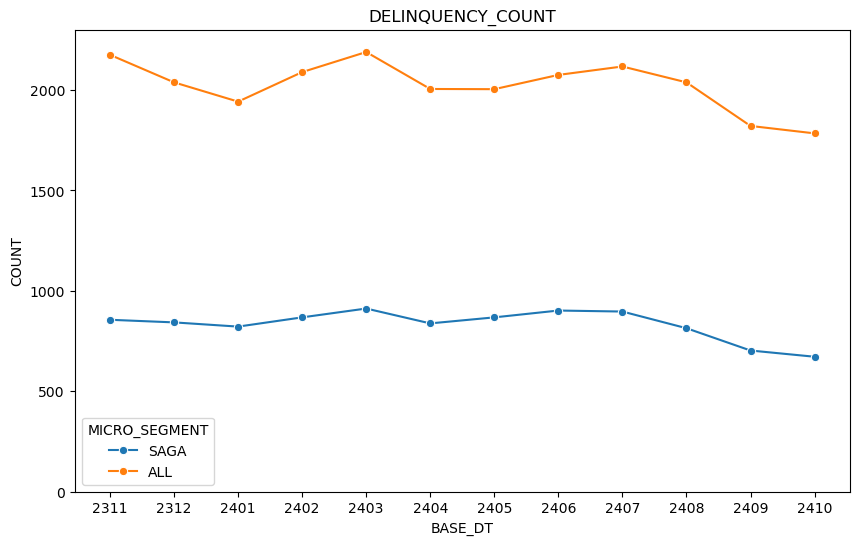

In [87]:
# concat data
GCIFPlot1 = pd.concat([SAGADeliGCIFCount,TotalDeliGCIFCount])
GCIFPlot1['BASE_DT'] = GCIFPlot1['BASE_DT'].str[2:6]

# Plot delinquency count per month
plt.figure(figsize=(10,6))
plt.title("DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
plt.ylim((0,2300))
sns.lineplot(data=GCIFPlot1, x="BASE_DT", y='CUST_NUM', hue='MICRO_SEGMENT', marker="o")

### b. SAGA Total vs Delinquency

<Axes: title={'center': 'SAGA_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

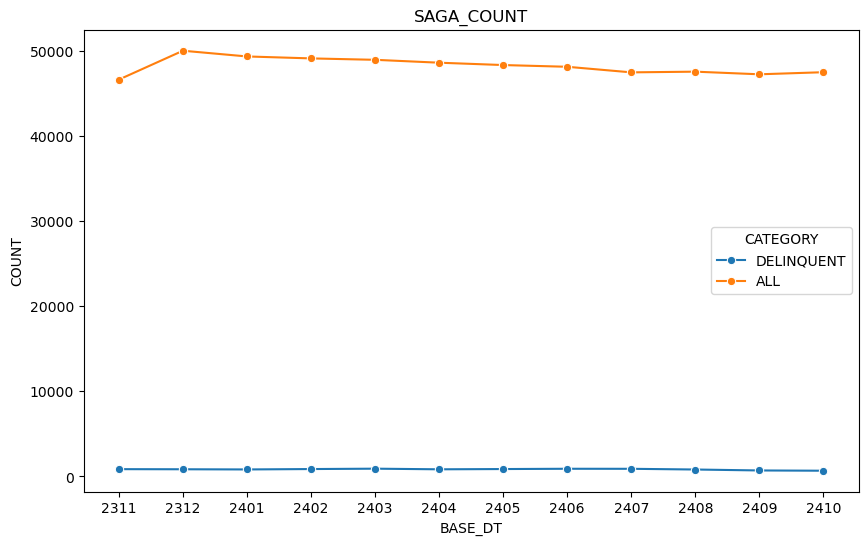

In [134]:
# concat data
GCIFPlot2 = pd.concat([SAGADeliGCIFCount,SAGAGCIFCount])
GCIFPlot2['BASE_DT'] = GCIFPlot2['BASE_DT'].str[2:6]

# Plot delinquency count per month
plt.figure(figsize=(10,6))
plt.title("SAGA_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
#plt.ylim((0,2300))
sns.lineplot(data=GCIFPlot2, x="BASE_DT", y='CUST_NUM', hue='CATEGORY', marker="o")

In [135]:
# create wide df to calaculate percentage
GCIFPlot2Wide = GCIFPlot2[GCIFPlot2['CATEGORY']=='DELINQUENT'].merge(
    GCIFPlot2[GCIFPlot2['CATEGORY']=='ALL'], on='BASE_DT', how='left')

In [136]:
GCIFPlot2Wide.columns

Index(['BASE_DT', 'CUST_NUM_x', 'TOTAL_LMT_x', 'TOTAL_BAL_x', 'TOTAL_NOA_x',
       'MICRO_SEGMENT_x', 'CATEGORY_x', 'CUST_NUM_y', 'TOTAL_LMT_y',
       'TOTAL_BAL_y', 'TOTAL_NOA_y', 'MICRO_SEGMENT_y', 'CATEGORY_y'],
      dtype='object')

In [137]:
# fix field names and shi
GCIFPlot2Wide.columns = ['BASE_DT', 'CUST_NUM_DELINQUENT', 'TOTAL_LMT_DELINQUENT',
                            'TOTAL_BAL_DELINQUENT', 'TOTAL_NOA_DELINQUENT', 'MICRO_SEGMENT_x',
                            'CATEGORY_x', 'CUST_NUM_ALL', 'TOTAL_LMT_ALL',
                            'TOTAL_BAL_ALL', 'TOTAL_NOA_ALL','MICRO_SEGMENT', 'CATEGORY_y']
GCIFPlot2Wide = GCIFPlot2Wide[['BASE_DT', 'CUST_NUM_DELINQUENT', 'TOTAL_LMT_DELINQUENT',
                            'TOTAL_BAL_DELINQUENT', 'TOTAL_NOA_DELINQUENT',
                            'CUST_NUM_ALL', 'TOTAL_LMT_ALL',
                            'TOTAL_BAL_ALL', 'TOTAL_NOA_ALL','MICRO_SEGMENT']]

In [138]:
# calculate count share
GCIFPlot2Wide['CUST_NUM_SHARE'] = GCIFPlot2Wide['CUST_NUM_DELINQUENT']/GCIFPlot2Wide['CUST_NUM_ALL']

# calculate os share
GCIFPlot2Wide['OS_SHARE'] = GCIFPlot2Wide['TOTAL_BAL_DELINQUENT']/GCIFPlot2Wide['TOTAL_BAL_ALL']

In [139]:
# longify for visualization
GCIFCountShare = GCIFPlot2Wide[['BASE_DT','CUST_NUM_SHARE']]
GCIFCountShare.columns = ['BASE_DT','SHARE']
GCIFCountShare['VAR'] = 'GCIF_COUNT'

GCIFOSShare = GCIFPlot2Wide[['BASE_DT','OS_SHARE']]
GCIFOSShare.columns = ['BASE_DT','SHARE']
GCIFOSShare['VAR'] = 'OS'

# concat the 2 tables
GCIFAllShare = pd.concat([GCIFCountShare,GCIFOSShare], ignore_index=True)
GCIFAllShare['BASE_DT'] = GCIFAllShare['BASE_DT'].str[2:6]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_7508\2687063092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GCIFCountShare['VAR'] = 'GCIF_COUNT'
C:\Users\MR38804\AppData\Local\Temp\ipykernel_7508\2687063092.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GCIFOSShare['VAR'] = 'OS'


<Axes: title={'center': 'SAGA_DELINQUENCY_SHARE'}, xlabel='BASE_DT', ylabel='SHARE'>

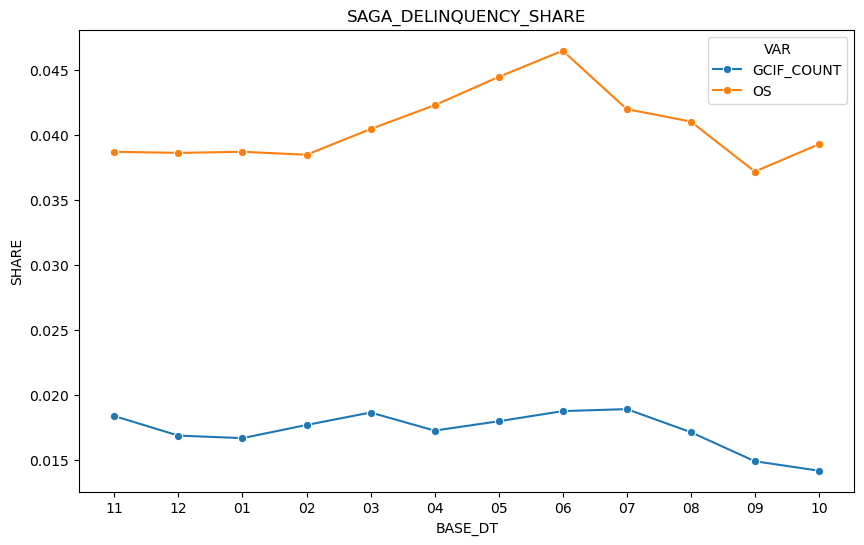

In [140]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("SAGA_DELINQUENCY_SHARE")
plt.xlabel("BASE_DT")
plt.ylabel("SHARE")
sns.lineplot(data=GCIFAllShare, x="BASE_DT", y='SHARE', hue='VAR', marker="o")

### c. All Total vs Delinquent

<Axes: title={'center': 'ALL_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

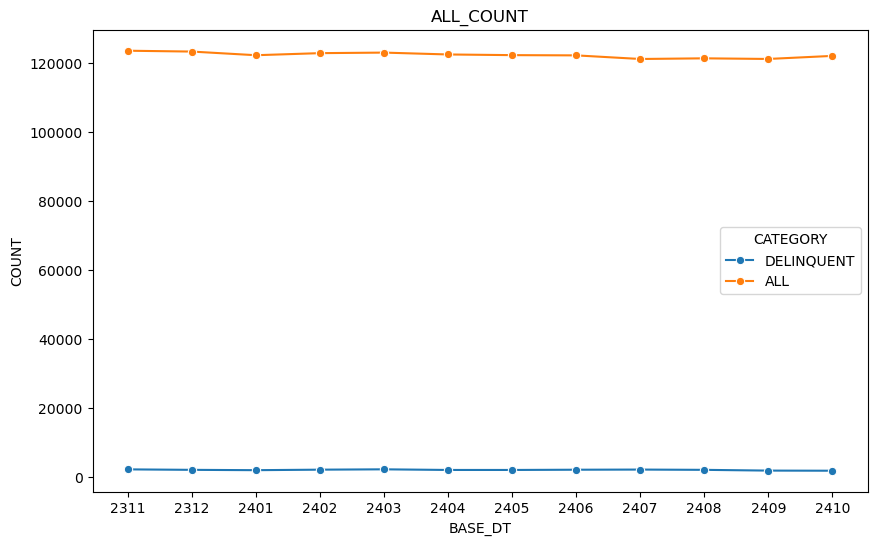

In [141]:
# concat data
GCIFPlot3 = pd.concat([TotalDeliGCIFCount,TotalGCIFCount])
GCIFPlot3['BASE_DT'] = GCIFPlot3['BASE_DT'].str[2:6]

# Plot delinquency count per month
plt.figure(figsize=(10,6))
plt.title("ALL_COUNT")
plt.xlabel("BASE_DT")
plt.ylabel("COUNT")
#plt.ylim((0,2300))
sns.lineplot(data=GCIFPlot3, x="BASE_DT", y='CUST_NUM', hue='CATEGORY', marker="o")

In [142]:
# create wide df to calaculate percentage
GCIFPlot3Wide = GCIFPlot3[GCIFPlot3['CATEGORY']=='DELINQUENT'].merge(
    GCIFPlot3[GCIFPlot3['CATEGORY']=='ALL'], on='BASE_DT', how='left')

In [143]:
# fix field names and shi
GCIFPlot3Wide.columns = ['BASE_DT', 'CUST_NUM_DELINQUENT', 'TOTAL_LMT_DELINQUENT',
                            'TOTAL_BAL_DELINQUENT', 'TOTAL_NOA_DELINQUENT', 'MICRO_SEGMENT_x',
                            'CATEGORY_x', 'CUST_NUM_ALL', 'TOTAL_LMT_ALL',
                            'TOTAL_BAL_ALL', 'TOTAL_NOA_ALL','MICRO_SEGMENT', 'CATEGORY_y']
GCIFPlot3Wide = GCIFPlot3Wide[['BASE_DT', 'CUST_NUM_DELINQUENT', 'TOTAL_LMT_DELINQUENT',
                            'TOTAL_BAL_DELINQUENT', 'TOTAL_NOA_DELINQUENT',
                            'CUST_NUM_ALL', 'TOTAL_LMT_ALL',
                            'TOTAL_BAL_ALL', 'TOTAL_NOA_ALL','MICRO_SEGMENT']]

In [144]:
# calculate count share
GCIFPlot3Wide['CUST_NUM_SHARE'] = GCIFPlot3Wide['CUST_NUM_DELINQUENT']/GCIFPlot3Wide['CUST_NUM_ALL']

# calculate os share
GCIFPlot3Wide['OS_SHARE'] = GCIFPlot3Wide['TOTAL_BAL_DELINQUENT']/GCIFPlot3Wide['TOTAL_BAL_ALL']

In [145]:
# longify for visualization
AllGCIFCountShare = GCIFPlot3Wide[['BASE_DT','CUST_NUM_SHARE']]
AllGCIFCountShare.columns = ['BASE_DT','SHARE']
AllGCIFCountShare['VAR'] = 'GCIF_COUNT'

AllGCIFOSShare = GCIFPlot3Wide[['BASE_DT','OS_SHARE']]
AllGCIFOSShare.columns = ['BASE_DT','SHARE']
AllGCIFOSShare['VAR'] = 'OS'

# concat the 2 tables
AllGCIFAllShare = pd.concat([AllGCIFCountShare,AllGCIFOSShare], ignore_index=True)
AllGCIFAllShare['BASE_DT'] = AllGCIFAllShare['BASE_DT'].str[2:6]

C:\Users\MR38804\AppData\Local\Temp\ipykernel_7508\3087575407.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllGCIFCountShare['VAR'] = 'GCIF_COUNT'
C:\Users\MR38804\AppData\Local\Temp\ipykernel_7508\3087575407.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AllGCIFOSShare['VAR'] = 'OS'


<Axes: title={'center': 'ALL_DELINQUENCY_SHARE'}, xlabel='BASE_DT', ylabel='SHARE'>

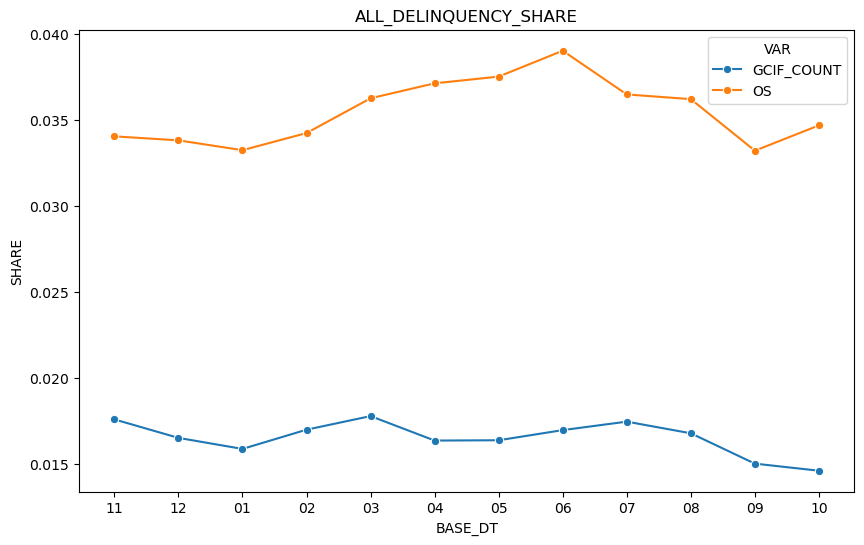

In [146]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("ALL_DELINQUENCY_SHARE")
plt.xlabel("BASE_DT")
plt.ylabel("SHARE")
sns.lineplot(data=AllGCIFAllShare, x="BASE_DT", y='SHARE', hue='VAR', marker="o")

### d. SAGA Monthly New Delinquent

In [101]:
# set dataframe for dpd change calculation
DPDMonthlyGCIF = MLsGCIF[['BASE_DT', 'GCIF_NO', 'PASTDUE_DAYS_MAX']].reset_index()

In [102]:
# create pivot table
DPDMonthlyGCIFPivot = DPDMonthlyGCIF.pivot(index='GCIF_NO',
                                   columns='BASE_DT',
                                   values='PASTDUE_DAYS_MAX')

In [103]:
# flaten columns
DPDMonthlyGCIFPivot = DPDMonthlyGCIFPivot.rename_axis(index=None, columns=None).reset_index()

In [104]:
DPDMonthlyGCIFPivot.columns

Index(['index', '20231130', '20231229', '20240131', '20240229', '20240328',
       '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
       '20241031'],
      dtype='object')

In [105]:
# rename columns
DPDMonthlyGCIFPivot.columns = [
    'GCIF_NO', '20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']

In [106]:
# fillna with 0
DPDMonthlyGCIFPivot.fillna(0, inplace=True)

# date for loop
dateCol = ['20231130', '20231229', '20240131', '20240229', '20240328',
    '20240430', '20240531', '20240628', '20240731', '20240829', '20240930',
    '20241031']

# calculate dpd change for all dates
for i in range(1,len(dateCol)):
    prevDate = dateCol[i-1]
    date = dateCol[i]
    DPDMonthlyGCIFPivot[f'DELINQUENT_{date}'] = DPDMonthlyGCIFPivot.apply(
        lambda x: 1 if x[prevDate]<30 and x[date]>=30 else 0,
        axis=1)

In [108]:
# check value
DPDMonthlyGCIFPivot[['DELINQUENT_20240430']].value_counts()

DELINQUENT_20240430
0                      144343
1                         499
Name: count, dtype: int64

In [110]:
# take only used cols
usedCols = [list(DPDMonthlyGCIFPivot.columns)[0]]+list(DPDMonthlyGCIFPivot.columns)[13:]
DPDMonthlyGCIFPivot = DPDMonthlyGCIFPivot[usedCols]

In [112]:
# longify
DPDMonthlyGCIFLong = pd.wide_to_long(DPDMonthlyGCIFPivot,
                                 stubnames='DELINQUENT',
                                 i = 'GCIF_NO',
                                 j = 'BASE_DT',
                                 sep = '_')

In [113]:
# reset index and change base_dt type to string
DPDMonthlyGCIFLong = DPDMonthlyGCIFLong.reset_index()
DPDMonthlyGCIFLong['BASE_DT'] = DPDMonthlyGCIFLong['BASE_DT'].astype(str)

In [114]:
DPDMonthlyGCIFLong.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1593262 entries, 0 to 1593261
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   GCIF_NO     1593262 non-null  object
 1   BASE_DT     1593262 non-null  object
 2   DELINQUENT  1593262 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 36.5+ MB


In [115]:
# merge delinquency flag to original data
MLsGCIF = MLsGCIF.merge(DPDMonthlyGCIFLong[['GCIF_NO', 'BASE_DT', 'DELINQUENT']], on=['GCIF_NO', 'BASE_DT'], how='left')

In [117]:
MLsGCIF['DELINQUENT'].value_counts()

DELINQUENT
0.0    1339078
1.0       6276
Name: count, dtype: int64

In [120]:
# group data for visualization
monthlyGCIFDeli = MLsGCIF[(MLsGCIF['SAGA_FLAG']=='SAGA') & (MLsGCIF['DELINQUENT']==1)][['BASE_DT', 'DELINQUENT', 'SUM_BAL']].groupby('BASE_DT').agg(GCIF_COUNT=('DELINQUENT','sum'), OS=('SUM_BAL','sum')).reset_index()
monthlyGCIFDeliAll = MLsGCIF[MLsGCIF['DELINQUENT']==1][['BASE_DT', 'DELINQUENT','SUM_BAL']].groupby('BASE_DT').agg(GCIF_COUNT=('DELINQUENT','sum'), OS=('SUM_BAL','sum')).reset_index()

In [121]:
# flag data
monthlyGCIFDeli['MICRO_SEGMENT'] = 'SAGA'
monthlyGCIFDeliAll['MICRO_SEGMENT'] = 'ALL'

In [122]:
# combine the data
MonthlyGCIFDeliComb = pd.concat([monthlyGCIFDeli,monthlyGCIFDeliAll], ignore_index=True)

# format data
MonthlyGCIFDeliComb['BASE_DT'] = MonthlyGCIFDeliComb['BASE_DT'].str[2:6]

# exclude first month because no data of new delinquency
MonthlyGCIFDeliComb = MonthlyGCIFDeliComb[MonthlyDeliComb['BASE_DT']!='2311']

<Axes: title={'center': 'MONTHLY_DELINQUENCY_COUNT'}, xlabel='BASE_DT', ylabel='COUNT'>

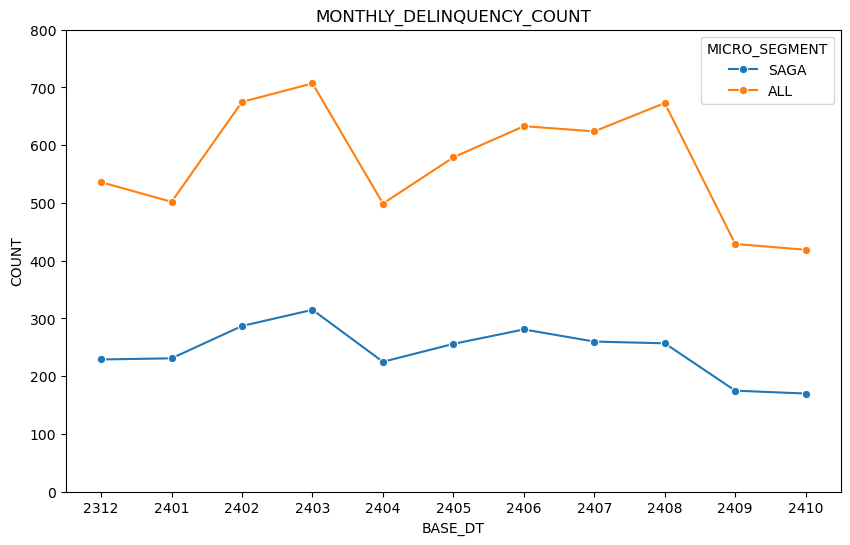

In [126]:
# Plotting
plt.figure(figsize=(10,6))
plt.title("MONTHLY_DELINQUENCY_COUNT")
plt.xlabel("BASE_DT")
plt.ylim((0,800))
plt.ylabel("COUNT")
sns.lineplot(data=MonthlyGCIFDeliComb, x="BASE_DT", y='GCIF_COUNT', hue='MICRO_SEGMENT', marker="o")

## 3. Distribution

In [147]:
MLs

,BASE_DT,AGREE_ID,GCIF_NO,CIF_NO,NOTE_NO,PRD_TP,PRD_NM,PRD_SEGMENT,ORG_LMT_AMT,CURR_LMT_AMT,BAL,ORIG_INT_RT,CURR_INT_RT,OTH_CURR_INT_RT,CLCT_RTNG_FCL,ALLOW_PCT,ALLOW_PCT_ADD,RESTRUCT_CD,PASTDUE_SINCE_DT,PASTDUE_DAYS,WRITE_OFF_AMT,WRITE_OFF_DT,WRITE_OFF_YN,CC_STATUS,SEGMENT,CUST_NM,OPEN_DATE,LAST_ACTIVE_DATE,CUST_TP,GENDER_CD,AGE,SAGA_FLAG,EMPLOYMENT_TYPE,CA_BAL,CA_AVG,SA_BAL,SA_AVG,TD_NOA,TD_BAL,TD_AVG,SY_FUNDING_BAL,SY_FUNDING_AVG,FUNDING_NOA,FUNDING_BAL,FUNDING_AVG,NOA_DORMANT,CC_PLAFOND,CC_BAL,PL_PLAFOND,PLOAN_BAL,TR_PLAFOND,TR_BAL,PB_PLAFOND,PB_BAL,PRK_PLAFOND,PRK_BAL,PPB_PLAFOND,PPB_BAL,BG_PLAFOND,BG_BAL,LC_PLAFOND,LC_BAL,SY_LOAN_PLAFOND,SY_LOAN_BAL,KPR_PLAFOND,KPR_BAL,KPM_PLAFOND,KPM_BAL,COLLECT,MF_BAL,BONDS_BAL,TRB,M2U_TRX_TOTAL,M2U_TRXAMT_FIN,CRTRX_MTD,CRTRX_AMT_MTD,DBTRX_MTD,DBTRX_AMT_MTD,DELINQUENT
0,20241031,CP0010014423730014818002,G500024500,1010001100195084,4423730014818002,001,Credit Card,031100,13000000.0,5000.0,0.0,0.21,0.21,0.21,00001,0.01,0.0,00001,99991231,0,0.0,None,N,PERFORMING,None,MERIANA,1989-04-20 00:00:00,NaT,INDV,F,91.0,SAGA,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20241031,CP0010014423730018812019,G000077677,1010001100983026,4423730018812019,001,Credit Card,031100,3440700.0,3539700.0,0.0,0.21,0.21,0.21,00001,0.01,0.0,00001,99991231,0,0.0,None,N,PERFORMING,None,ESTRELITTA S,1996-05-28 00:00:00,NaT,INDV,F,63.0,SAGA,OTHERS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3440700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20241031,CP0010014423730019420010,G900427519,1050550000481219,4423730019420010,001,Credit Card,031100,15000000.0,18000000.0,0.0,0.21,0.21,0.21,00001,0.01,0.0,00001,99991231,0,0.0,None,N,PERFORMING,None,KABUL TAUFIK,1994-06-30 00:00:00,NaT,INDV,M,66.0,SAGA,OTHERS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20241031,CP0010014423730019660060,G500018452,1010001100101413,4423730019660060,001,Credit Card,031100,20000000.0,30000000.0,0.0,0.21,0.21,0.21,00001,0.01,0.0,00001,99991231,0,0.0,None,N,PERFORMING,None,HALIM,1991-04-06 00:00:00,NaT,INDV,M,91.0,SAGA,OTHERS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20241031,CP0010014423730022781028,G600368005,1030050000355591,4423730022781028,001,Credit Card,031100,78000000.0,141700000.0,0.0,0.21,0.21,0.21,00001,0.01,0.0,00001,99991231,0,0.0,None,N,PERFORMING,None,KWAN KWIK SEN,1991-07-27 00:00:00,NaT,INDV,M,65.0,SAGA,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141700000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177445,20231130,CP0016314649870017063004,G108876277,0000000085328011,4649870017063004,001,Credit Card,031100,0.0,588600.0,588600.0,0.21,0.21,0.21,00001,0.01,0.0,00001,99991231,0,0.0,None,N,PERFORMING,None,"WOM FINANCE, PT",1900-01-01,NaT,CORP,None,59.0,SAGA,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,500000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500000000.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2177446,20231130,CP0016314649870017611000,G004093340,0000000027790013,4649870017611000,001,Credit Card,031100,20000000.0,30000000.0,0.0,

### a. BAL by SAGA_FLAG and CC_STATUS

c:\Users\MR38804\AppData\Local\anaconda3\envs\Py64\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


<Axes: xlabel='SAGA_FLAG', ylabel='BAL'>

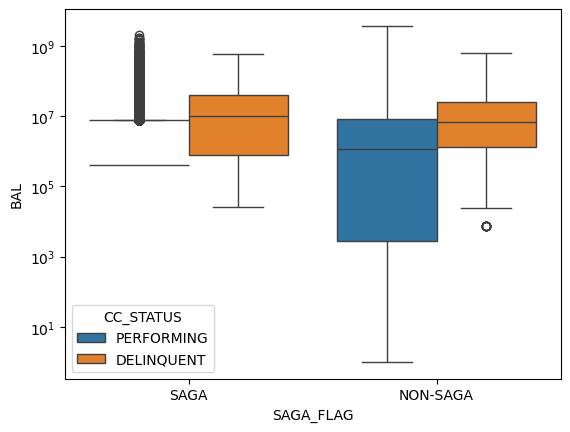

In [ ]:
# create BAL boxplot by SAGA FLAG
sns.boxplot(data=MLs, x="SAGA_FLAG", y="BAL", hue="CC_STATUS", log_scale=True)

### b. LMT by SAGA_FLAG and CC_STATUS

<Axes: xlabel='SAGA_FLAG', ylabel='CURR_LMT_AMT'>

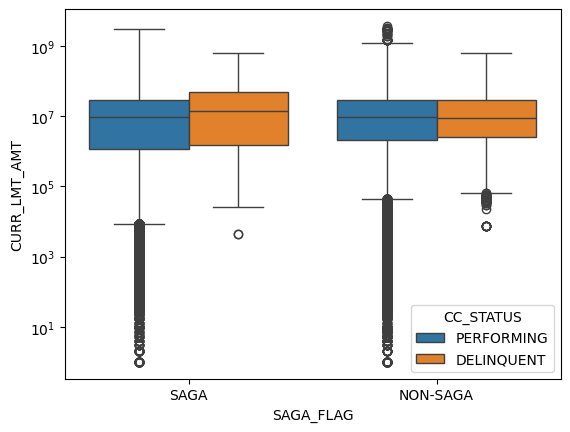

In [154]:
# create LMT boxplot by SAGA FLAG
sns.boxplot(data=MLs, x="SAGA_FLAG", y="CURR_LMT_AMT", hue="CC_STATUS", log_scale=True)

### c. Monthly Delinquentts by SAGA_FLAG and CC_STATUS

<Axes: xlabel='BASE_DT', ylabel='BAL'>

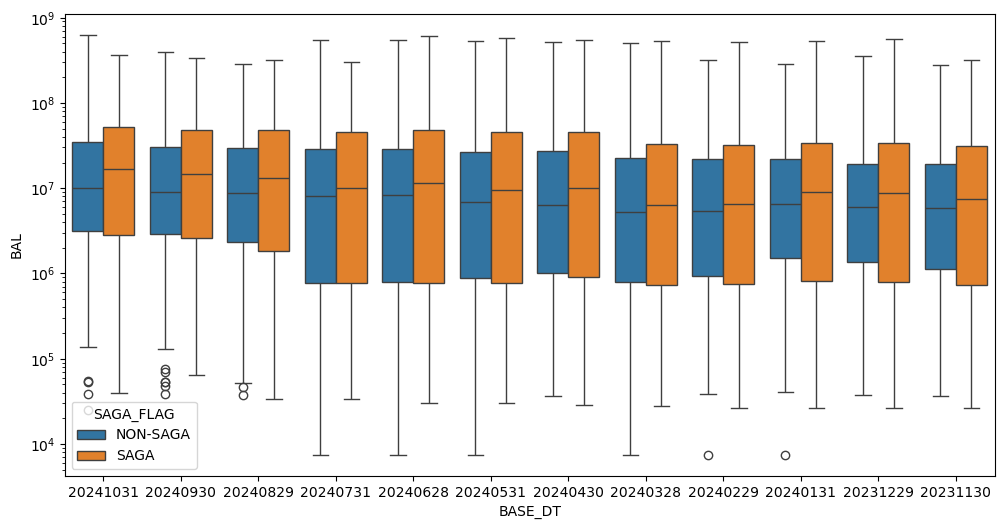

In [ ]:
# create boxplot MONTHLY
plt.title("MONTHLY_OS")
plt.figure(figsize=(12,6))
sns.boxplot(data=MLs[MLs['CC_STATUS']=='DELINQUENT'], x="BASE_DT", y="BAL", hue="SAGA_FLAG", log_scale=True)

<Axes: xlabel='BASE_DT', ylabel='CURR_LMT_AMT'>

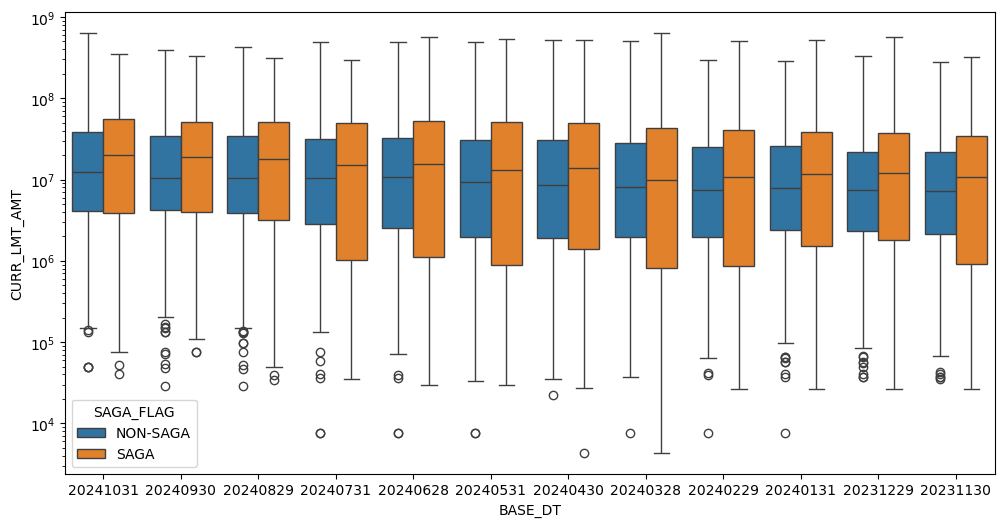

In [157]:
# create boxplot MONTHLY
plt.figure(figsize=(12,6))
sns.boxplot(data=MLs[MLs['CC_STATUS']=='DELINQUENT'], x="BASE_DT", y="CURR_LMT_AMT", hue="SAGA_FLAG", log_scale=True)

### d. Utilization

In [ ]:
MLs['UTIL'] = MLs.apply(lambda x: x['BAL']/x['CURR_LMT_AMT'] if x['CURR_LMT_AMT']>0 else 0, axis=1)